# **Deep Learning - Final Project**



---




### **Team name: Pain & Panic**

team members: 
T63K63 - Tugyi Beatrix,

IT9P0Z - Heizer Levente

# Imports

In [7]:
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install csrgraph

import torch
!pip install torch_geometric

from torch import nn
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

!pip install nodevectors

import re
import networkx as nx

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import time
import warnings
warnings.simplefilter("ignore", category=UserWarning)
!pip install gensim==3.6
import gensim
warnings.simplefilter("default", category=UserWarning)

import csrgraph as cg
from nodevectors.embedders import BaseNodeEmbedder
! pip install  torch_scatter

You should consider upgrading via the '/Users/levente.heizer/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.6 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 6.0 MB/s eta 0:00:011
     |████████████████████████████████| 3.5 MB 8.7 MB/s eta 0:00:01
     |████████████████████████████████| 257 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 7.3 MB/s eta 0:00:01
You should consider upgrading via the '/Users/levente.heizer/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/levente.heizer/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/levente.heizer/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/levente.heizer/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --up

In [23]:
!pip install networkx

You should consider upgrading via the '/Users/levente.heizer/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.


In [8]:
from nodevectors import Node2Vec

In [9]:
from torch_geometric.transforms import RandomLinkSplit
import requests
import torch_scatter

In [10]:
from torch_geometric.nn import GINConv

In [11]:
from torch_geometric.nn import  MLP

In [25]:
nx.adj_matrix = nx.adjacency_matrix

In [32]:
# Node2Vec
class Node2Vec_2(BaseNodeEmbedder):
    def __init__(
        self,
        n_components=32,
        walklen=30,
        epochs=20,
        return_weight=1.,
        neighbor_weight=1.,
        threads=0,
        keep_walks=False,
        verbose=True,
        w2vparams={"window":10, "negative":5, "iter":10,
                   "batch_words":128}):

        if type(threads) is not int:
            raise ValueError("Threads argument must be an int!")
        if walklen < 1 or epochs < 1:
            raise ValueError("Walklen and epochs arguments must be > 1")
        self.n_components = n_components
        self.walklen = walklen
        self.epochs = epochs
        self.keep_walks = keep_walks
        if 'size' in w2vparams.keys():
            raise AttributeError("Embedding dimensions should not be set "
                + "through w2v parameters, but through n_components")
        self.w2vparams = w2vparams
        self.return_weight = return_weight
        self.neighbor_weight = neighbor_weight
        if threads == 0:
            threads = numba.config.NUMBA_DEFAULT_NUM_THREADS
        self.threads = threads
        w2vparams['workers'] = threads
        self.verbose = verbose

    def fit(self, G):
        """
        NOTE: Currently only support str or int as node name for graph
        Parameters
        ----------
        G : graph data
            Graph to embed
            Can be any graph type that's supported by csrgraph library
            (NetworkX, numpy 2d array, scipy CSR matrix, CSR matrix components)
        """
        if not isinstance(G, cg.csrgraph):
            G = cg.csrgraph(G, threads=self.threads)
        if G.threads != self.threads:
            G.set_threads(self.threads)
        # Because networkx graphs are actually iterables of their nodes
        #   we do list(G) to avoid networkx 1.X vs 2.X errors
        node_names = G.names
        if type(node_names[0]) not in [int, str, np.int32, np.uint32,
                                       np.int64, np.uint64]:
            raise ValueError("Graph node names must be int or str!")
        # Adjacency matrix
        walks_t = time.time()
        if self.verbose:
            print("Making walks...", end=" ")
        self.walks = G.random_walks(walklen=self.walklen,
                                    epochs=self.epochs,
                                    return_weight=self.return_weight,
                                    neighbor_weight=self.neighbor_weight)
        if self.verbose:
            print(f"Done, T={time.time() - walks_t:.2f}")
            print("Mapping Walk Names...", end=" ")
        map_t = time.time()
        self.walks = pd.DataFrame(self.walks)
        # Map nodeId -> node name
        node_dict = dict(zip(np.arange(len(node_names)), node_names))
        for col in self.walks.columns:
            self.walks[col] = self.walks[col].map(node_dict).astype(str)
        # Somehow gensim only trains on this list iterator
        # it silently mistrains on array input
        self.walks = [list(x) for x in self.walks.itertuples(False, None)]
        if self.verbose:
            print(f"Done, T={time.time() - map_t:.2f}")
            print("Training W2V...", end=" ")
            if gensim.models.word2vec.FAST_VERSION < 1:
                print("WARNING: gensim word2vec version is unoptimized"
                    "Try version 3.6 if on windows, versions 3.7 "
                    "and 3.8 have had issues")
        w2v_t = time.time()
        # Train gensim word2vec model on random walks
        self.model = gensim.models.Word2Vec(
            sentences=self.walks,
            size=self.n_components, #!!!!
            **self.w2vparams)
        if not self.keep_walks:
            del self.walks
        if self.verbose:
            print(f"Done, T={time.time() - w2v_t:.2f}")

    def fit_transform(self, G):
        """
        NOTE: Currently only support str or int as node name for graph
        Parameters
        ----------
        G : graph data
            Graph to embed
            Can be any graph type that's supported by csrgraph library
            (NetworkX, numpy 2d array, scipy CSR matrix, CSR matrix components)
        """
        if not isinstance(G, cg.csrgraph):
            G = cg.csrgraph(G, threads=self.threads)
        self.fit(G)
        w = np.array(
            pd.DataFrame.from_records(
            pd.Series(np.arange(len(G.nodes())))
              .apply(self.predict)
              .values)
        )
        return w

    def predict(self, node_name):
        """
        Return vector associated with node
        node_name : str or int
            either the node ID or node name depending on graph format
        """
        # current hack to work around word2vec problem
        # ints need to be str -_-
        if type(node_name) is not str:
            node_name = str(node_name)
        return self.model.wv.__getitem__(node_name)

    def save_vectors(self, out_file):
        """
        Save as embeddings in gensim.models.KeyedVectors format
        """
        self.model.wv.save_word2vec_format(out_file)

    def load_vectors(self, out_file):
        """
        Load embeddings from gensim.models.KeyedVectors format
        """
        self.model = gensim.wv.load_word2vec_format(out_file)

# Set the device to Cuda if GPU is available

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utilities

In [13]:
# function to get the first part of the file names of each given file
# in the Facebook graph these are the indexes of the ego-s (the individuals ) )
def get_ego_indexes(files):
  pattern = re.compile(r'\d+')
  ego_indexes = [int(pattern.search(s).group()) for s in files if pattern.search(s)]
  ego_indexes = sorted(set(ego_indexes))
  return ego_indexes

In [14]:
# Class to store all the information about the given graphs
class GraphData:
  edge_index = []
  edge_list = []
  nodes = []
  X = []
  circles = []
  X_names = []
  embeddings = []

  def __init__(self, edges, edge_list, X, circles, X_names, embeddings, nodes):
    self.edge_index = edges
    self.edge_list = edge_list
    self.X = X
    self.circles = circles
    self.X_names = X_names
    self.embeddings = embeddings
    self.nodes = nodes

In [15]:
#This function is to visualize the given graph
def visualize(g, title="Graph", edge='blue'):
    pos = nx.kamada_kawai_layout(g)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.axis('on')
    nx.draw_networkx(g, pos=pos, node_size=10,
                     arrows=False, width=1, style='solid', with_labels= False)
    plt.show()

In [110]:
#This function is for split a graph data's edges into test, validation and train set
def split_data(graph, embeddings_type = 0):
  split = RandomLinkSplit(
      num_val=0.05,  # size of the validation set
      num_test=0.1,  # size of the test set
      is_undirected=True,
      add_negative_train_samples=False, # We do not want negativ edges in the traing set
      neg_sampling_ratio=1.0,   # In the test and validation set the num of negativ edges will be the same as the positives
  )
  # embedding_type is 0, when we want to use the embeddings of the nodes, given by the Node2Vec algorithm
  # if its 1, we use the original representations of the nodes (X) and when it's two we use both of them
  if embeddings_type == 0:
     data = Data(x=graph.embeddings, edge_index=graph.edge_index)
  elif embeddings_type == 1:
     data = Data(x=graph.X, edge_index=graph.edge_index) 
  else:
     data = Data(x=torch.cat((graph.X, graph.embeddings), dim=1), edge_index=graph.edge_index)
     
        
  train_data, val_data, test_data = split(data)

  # print('train_data:', train_data)
  # print('val_data:', val_data)
  # print('test_data:', test_data)
  return train_data, val_data, test_data

# Facebook dataset

### Data acquisition

In [17]:
#Facebook subgraphs
url = 'https://snap.stanford.edu/data/facebook.tar.gz'
r = requests.get(url, allow_redirects=True)
open('facebook.tar.gz', 'wb').write(r.content)

# on Google colab use this instead:  !wget https://snap.stanford.edu/data/facebook.tar.gz

732104

In [18]:
#The whole graph
url = 'https://snap.stanford.edu/data/facebook_combined.txt.gz'
r = requests.get(url, allow_redirects=True)
open('facebook_combined.txt.gz', 'wb').write(r.content)


218576

In [19]:
# unzip the whoke graph
import gzip
with gzip.open('facebook_combined.txt.gz', 'rt') as f:
    content = f.read()
with open('facebook_combined.txt', 'w') as f:
    f.write(content)

In [20]:
# Unzip the file of the subgraphs
files = ! tar xvzf facebook.tar.gz

## data preparation for the subgraphs

In [21]:
# Gettting and listing the indexes of the files
Fb_ego_indexes = get_ego_indexes(files)
print("indexes of the subgraphs:", Fb_ego_indexes)
print("Num of the subgraphs", len(Fb_ego_indexes))

indexes of the subgraphs: [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]
Num of the subgraphs 10


## Convert the text data to graph and create embeddings with Node2Vec

In [35]:
# Empty list for the graphs
Facebook_graphs = []
# For all subgraph we process each file, which contains it's elements
for index in range(len(Fb_ego_indexes)):
  
  # First, we load the edges and save them in two different format: edges is a list of the edge pairs and
  # edge_index conitains the edges in a two dimensional matrix, each index of this matrix represnt an edge, this
  # is useful if we use pytorcg geometric for handle the graph data
  f = open(f'facebook/{Fb_ego_indexes[index]}.edges', "rt")
  edges_str = f.readlines()
  edge_index = [list(map(int, item.strip().split())) for item in edges_str]
  # Transpose the data to get desired format
  edge_index = torch.tensor([list(row) for row in zip(*edge_index)])
  edge_list =   [(int(x.split()[0]), int(x.split()[1])) for x in edges_str]
  f = open(f'facebook/{Fb_ego_indexes[index]}.circles', "rt")
   
  # These are the social circles in the graph
  circles_str = f.readlines()
  circles = [list(map(int, item.split('\t')[1:])) for item in circles_str]

  #Here we collect the name of each feauture in the graph
  f = open(f'facebook/{Fb_ego_indexes[index]}.featnames', "rt")
  feat_name_str = f.readlines()
  X_names = [item.split(';anonymized feature')[0].split(';') for item in feat_name_str]

  # These are the features for the "ego" of the graph (ego means the person whose connenctions are in the given subgraph)
  #f = open(f'facebook/{Fb_ego_indexes[index]}.egofeat', "rt")
  #feat_str = f.readlines()
  #X = []
  #X.append(list(map(int, feat_str[0].split()[1:])) )
  #X = torch.tensor(X)
  # These are the features for all the nodes of the graph, except the ego
  f = open(f'facebook/{Fb_ego_indexes[index]}.feat', "rt")
  feat_str = f.readlines()
  
  index = torch.tensor([int(list(map(int, item.split()))[0]) for item in feat_str])
  # töröljük az olyan indexű csúcsokat amik mar voltak
  X_ego = torch.tensor([list(map(int, item.split()[1:]))[0:-1] for item in feat_str])
  #X = torch.cat([ torch.empty(), X_ego], dim=0)
  X = torch.tensor(X_ego)

    
  # Node mapping
  node_mapping = {old.item(): new  for new, old in enumerate(index)}
                                      
  mapped_edge_index = torch.tensor([[node_mapping[n.item()] for n in edge_index[0]],
                                [node_mapping[n.item()] for n in edge_index[1]]])
         
  # Here we convert our graph, because Node2Vec expects an NX graph     
  G = nx.from_edgelist(mapped_edge_index.T.numpy())
  # When we transform the graph this way, we lose the isolated nodes ( the ones that only connect with the ego)
  # so with an extra step we add extra nodes to represent the isolated nodes
  max_ = torch.tensor(mapped_edge_index)[0, :].max()
  for node_id in range(max_ -1):
    if node_id not in G:
        G.add_node(node_id)
       
  # creating the Node2Vec embeddings 
  n2v = Node2Vec_2(n_components=64, walklen=10, epochs=50, return_weight=1.0, neighbor_weight=1.0, threads=0, w2vparams={'window': 4, 'negative': 5, 'iter':10, 'ns_exponent': 0.5, 'batch_words': 128})

  # Fit and get the embedding
  n2v.fit(G)
  #Getting the nodes of the graph
  nodes = G.nodes()
  embeddings = []
  for node in nodes:
    embeddings.append(n2v.predict(node))
  # Create the subgraph
  Facebook_graphs.append(GraphData(mapped_edge_index, edge_list, X.float(), circles, X_names, torch.tensor(embeddings), nodes))

/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.12
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=2.73


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  Facebook_graphs.append(GraphData(mapped_edge_index, edge_list, X.float(), circles, X_names, torch.tensor(embeddings), nodes))
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

Making walks... Done, T=0.04
Mapping Walk Names... Done, T=0.34
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=8.12


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.09
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=1.67
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.07
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Done, T=0.96
Making walks... Done, T=0.01
Mapping Walk Names... Done, T=0.07
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Done, T=1.22
Making walks... Done, T=0.00
Mapping Walk Names... Done, T=0.03
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Done, T=0.48


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Making walks... Done, T=0.03
Mapping Walk Names... Done, T=0.34
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=7.60


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Making walks... Done, T=0.03
Mapping Walk Names... Done, T=0.27
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=6.09


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Making walks... Done, T=0.02
Mapping Walk Names... Done, T=0.22
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=4.21
Making walks... Done, T=0.00
Mapping Walk Names... Done, T=0.03
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues


/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_ego)
/var/folders/rt/m8lgy8rx1g9gm36dlqs9w5v80000gn/T/ipykernel_63144/3402426009.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(mapped_edge_index)[0, :].max()


Done, T=0.33


### Testting the loaded graph

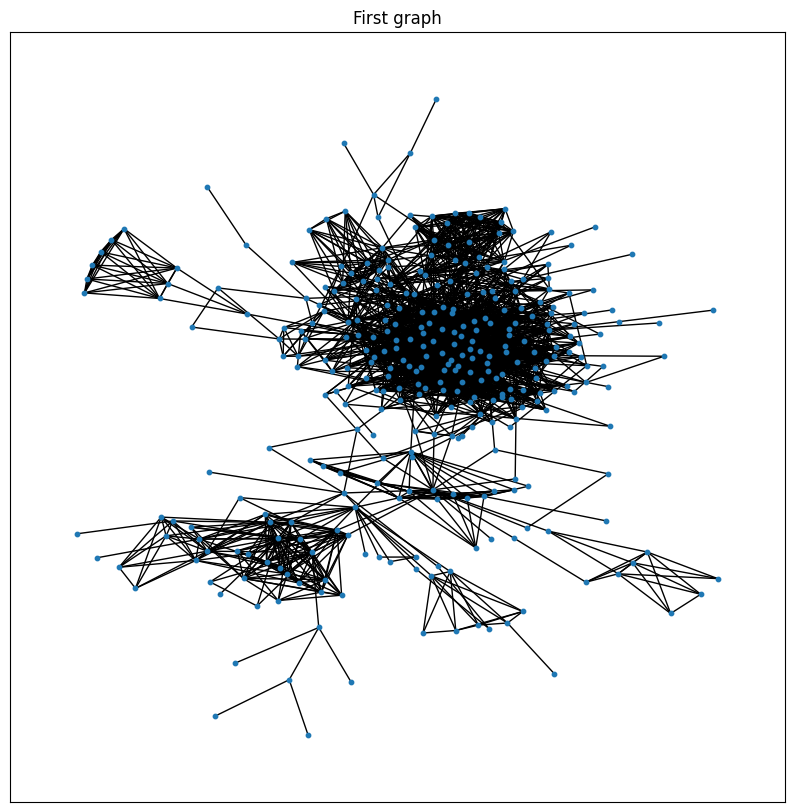

In [36]:
# Visualizaton of the first subgraph
Edge_graph = nx.from_edgelist(Facebook_graphs[0].edge_list)
visualize( Edge_graph, "First graph")

In [37]:
# The features of the fisrt graph's first node
Facebook_graphs[0].X[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [38]:
# The edges of the first graph
Facebook_graphs[0].edge_index

tensor([[235, 121,  23,  ...,  84,  97, 290],
        [185, 284, 345,  ...,  74, 331, 338]])

In [39]:
# The Node2Vec embeddings of the first graph
Facebook_graphs[0].embeddings

tensor([[-0.3273, -0.0683, -0.6082,  ..., -0.9174,  0.1121,  0.7848],
        [ 0.1300,  0.5535, -1.7004,  ...,  0.2409, -0.2794, -0.4891],
        [-0.2642,  0.5953, -1.1416,  ..., -0.5231, -0.0800,  0.4239],
        ...,
        [ 0.6694, -0.6022,  0.8000,  ..., -0.8031,  1.1758, -0.2747],
        [ 0.3068, -0.1589, -0.8870,  ..., -0.3824, -0.1656, -0.1606],
        [ 0.1630, -0.1081, -0.3489,  ..., -1.1519,  0.6749, -0.8254]])

In [40]:
#Names of the features in the first graph
Facebook_graphs[0].X_names

[['0 birthday'],
 ['1 birthday'],
 ['2 birthday'],
 ['3 birthday'],
 ['4 birthday'],
 ['5 birthday'],
 ['6 birthday'],
 ['7 birthday'],
 ['8 education', 'classes', 'id'],
 ['9 education', 'classes', 'id'],
 ['10 education', 'classes', 'id'],
 ['11 education', 'classes', 'id'],
 ['12 education', 'classes', 'id'],
 ['13 education', 'concentration', 'id'],
 ['14 education', 'concentration', 'id'],
 ['15 education', 'concentration', 'id'],
 ['16 education', 'concentration', 'id'],
 ['17 education', 'concentration', 'id'],
 ['18 education', 'concentration', 'id'],
 ['19 education', 'concentration', 'id'],
 ['20 education', 'degree', 'id'],
 ['21 education', 'degree', 'id'],
 ['22 education', 'degree', 'id'],
 ['23 education', 'degree', 'id'],
 ['24 education', 'school', 'id'],
 ['25 education', 'school', 'id'],
 ['26 education', 'school', 'id'],
 ['27 education', 'school', 'id'],
 ['28 education', 'school', 'id'],
 ['29 education', 'school', 'id'],
 ['30 education', 'school', 'id'],
 ['31 e

# Whole graph

In [41]:
f = open('facebook_combined.txt', "rt")
text = f.readlines()

all_edge_index = [(int(x.split()[0]), int(x.split()[1])) for x in text]  
all_edge_index = torch.tensor(all_edge_index).T
print(all_edge_index)

tensor([[   0,    0,    0,  ..., 4027, 4027, 4031],
        [   1,    2,    3,  ..., 4032, 4038, 4038]])


In [43]:
# Here we convert our graph, because Node2Vec expects an NX graph     
H = nx.from_edgelist(all_edge_index.T.numpy())
# When we transform the graph this way, we lose the isolated nodes ( the ones that only connect with the ego)
# so with an extra step we add extra nodes to represent the isolated nodes
max_ = all_edge_index[0, :].max()
for node_id in range(max_ -1):
    if node_id not in H:
        H.add_node(node_id)

# creating the Node2Vec embeddings 
n2v = Node2Vec_2(n_components=64, walklen=10, epochs=50, return_weight=1.0, neighbor_weight=1.0, threads=0, w2vparams={'window': 4, 'negative': 5, 'iter':10, 'ns_exponent': 0.5, 'batch_words': 128})

# Fit and get the embedding
n2v.fit(H)
#Getting the nodes of the graph
nodes = H.nodes()
embeddings = []
for node in nodes:
    embeddings.append(n2v.predict(node))

Making walks... Done, T=0.10
Mapping Walk Names... Done, T=1.39
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=27.14


In [44]:
# Class to store all the information about the given graphs
class GraphData2:
  edge_index = []
  embeddings = []

  def __init__(self, edges, embeddings):
    self.edge_index = edges 
    self.embeddings = embeddings
    


In [45]:
len(all_edge_index[0])

88234

# Link Prediction - GNN Autoencoder

### Training function

In [157]:
class GNNVAE(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GNNVAE,self).__init__()
    # GCN layers
    #self.GNNConvIn = GCNConv(in_channels=in_channels, out_channels=hidden_channels)
    #self.GNNConvHidden = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
    #self.GNNConvOut = GCNConv(in_channels=hidden_channels, out_channels=out_channels)

    self.GNNConvIn = GINConv(MLP([in_channels, hidden_channels, hidden_channels]))
    self.GNNConvHidden = GINConv(MLP([hidden_channels, hidden_channels, hidden_channels]))
    self.GNNConvOut = GINConv(MLP([hidden_channels, hidden_channels, out_channels]))
    
  # The encoder part is a GCN network
  def encode(self,x,edge_index):
    x = self.GNNConvIn(x,edge_index).relu()
    x = self.GNNConvOut(x,edge_index).relu()
    return x

  # The decoder part of the network 
  def decode(self,z,edges):
    return (z[edges[0]] * z[edges[1]]).sum(dim=-1)

  # training function
  def train_GNNVAE(self, train_dataset,val_dataset,optimizer,epoch,verbose=False):
    for epoch in range(0,epoch):
      self.train()
      optimizer.zero_grad()
      # Transport data to GPU if nessesery
      x, edge_index, edge_label_index = train_dataset.x.to(device), train_dataset.edge_index.to(device), train_dataset.edge_label_index.to(device)
     
      # The autoencoder's hidden representation
      z = self.encode(x,edge_index)
      
      # Adding negativ edges to the graph
      # The number of negativ edges will be the same as the positiv edges (num_neg_samples=len(edge_label_index[1]))
      neg_edge_index = negative_sampling(
              edge_index=edge_index, num_nodes=torch.tensor(train_dataset.num_nodes).to(device),
              num_neg_samples=len(edge_label_index[1]), method='sparse')
      
      # Adding the negativ edges to the original (positiv) edges of the graph 
      pos_neg_edge_index = torch.cat(
          [edge_label_index, neg_edge_index],
          dim=-1,
      )
    
      # Creating the ground truth labels for the edges: 0 if it's a negativ and 1 if it's a positiv edge
      edge_y = torch.cat([
          torch.ones(neg_edge_index.size(1)).to(device),
          train_dataset.edge_label.new_zeros(neg_edge_index.size(1)).to(device)
      ], dim=0)
      
      # decoder part of the autoencoder
      out = self.decode(z,pos_neg_edge_index)

      # Definiing our loss function
      loss_fn = torch.nn.BCEWithLogitsLoss()
      loss = loss_fn(out,edge_y)
      loss.backward()
      optimizer.step()

      # validation step
      if (verbose and epoch % 10 == 0):
        val_roc_auc = self.eval_GNNVAE(val_dataset)
        print(f"Train loss: {loss}\nValidation AUC: {val_roc_auc}")
    return self


  # Custum eval function
  @torch.no_grad()
  def eval_GNNVAE(self, data):
    self.eval()
     # Transport data to GPU if nessesery
    x, edge_index, edge_label_index = data.x.to(device), data.edge_index.to(device), data.edge_label_index.to(device)
    # The validation and test data already contain negative edges via Graph Link Split
    # So in this step we do not need to manually add them
    z = self.encode(x, edge_index)
    out = self.decode(z, edge_label_index).view(-1).sigmoid()
    #print(data.edge_label.cpu().numpy()[0:50],  np.round(out.cpu().numpy())[0:50])
    #print(data.edge_label.cpu().numpy()[-100:-50],  np.round(out.cpu().numpy())[-100:-50])
    y_true = data.edge_label.cpu().numpy()
    y_pred = np.round(out.cpu().numpy())
    acc = (y_pred == y_true).sum() / len(y_true)
    print(acc)
    roc =  roc_auc_score(y_true, y_pred)
    # print(classification_report(y_true, y_pred, labels=[0, 1]))
    # cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negativ edge","Positiv edge"])
    # disp.plot()
    # plt.show()
    
    # fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    # roc_auc = metrics.auc(fpr, tpr)
    # display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
    #                               estimator_name='example estimator')
    # display.plot()

    # plt.show()
    

    # Edge_graph = nx.from_edgelist(data.edge_label_index.T.numpy())

    #color_list = ["blue" if value == 1 else "red" for value in data.edge_label]
   
    # color_map = {
    # (0, 0): 'red',
    # (0, 1): 'blue',
    # (1, 0): 'yellow',
    # (1, 1): 'green'
    # }

    # Create a new list using the map
    # color_list = [color_map[(a, b)] for a, b in zip(y_pred, y_true)]
    # print(color_list.count('blue'))
    # print(color_list.count('red'))
    # print(color_list.count('yellow'))
    # print(color_list.count('green'))
    # visualize(Edge_graph, "Graph", color_list)
    return roc, acc

# Training

In [48]:
!pip install optuna

     |████████████████████████████████| 409 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 230 kB 4.8 MB/s eta 0:00:01
     |████████████████████████████████| 197 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 5.5 MB/s eta 0:00:011
     |████████████████████████████████| 264 kB 451 kB/s eta 0:00:01
You should consider upgrading via the '/Users/levente.heizer/.pyenv/versions/3.9.7/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
import optuna

## I. Traing for the whole facebook graph - with the Node2Vec embeddings

In [185]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 64)
    out_channels = trial.suggest_int('out_channels', 8, 32)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    graph = GraphData2(all_edge_index, torch.tensor(embeddings) )
    train_data, val_data, test_data = split_data(graph, 0)
    model = GNNVAE(train_data.x.shape[1], 32, 16).to(device)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

    model = model.train_GNNVAE(train_data, val_data, optimizer,300)
    test_auc_whole_graph, test_acc_whole_graph = model.eval_GNNVAE(test_data)
    return test_acc_whole_graph

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-10 18:28:24,920] A new study created in memory with name: no-name-350752f3-68ba-4399-808b-e2e6cbdd7405
[I 2023-12-10 18:29:26,815] Trial 0 finished with value: 0.933809361895047 and parameters: {'hidden_channels': 63, 'out_channels': 29, 'lr': 1.4786092616057319e-05}. Best is trial 0 with value: 0.933809361895047.


0.933809361895047


[I 2023-12-10 18:30:28,789] Trial 1 finished with value: 0.9278590048736257 and parameters: {'hidden_channels': 51, 'out_channels': 9, 'lr': 0.0026470918663182505}. Best is trial 0 with value: 0.933809361895047.


0.9278590048736257


[I 2023-12-10 18:31:34,590] Trial 2 finished with value: 0.9178284030375156 and parameters: {'hidden_channels': 51, 'out_channels': 8, 'lr': 0.001588452872901775}. Best is trial 0 with value: 0.933809361895047.


0.9178284030375156


[I 2023-12-10 18:32:36,694] Trial 3 finished with value: 0.9172050323019381 and parameters: {'hidden_channels': 57, 'out_channels': 28, 'lr': 0.022796448282868587}. Best is trial 0 with value: 0.933809361895047.


0.9172050323019381


[I 2023-12-10 18:33:35,297] Trial 4 finished with value: 0.9398730590502097 and parameters: {'hidden_channels': 57, 'out_channels': 20, 'lr': 0.000823381694526447}. Best is trial 4 with value: 0.9398730590502097.


0.9398730590502097


[I 2023-12-10 18:34:44,163] Trial 5 finished with value: 0.92904907627791 and parameters: {'hidden_channels': 55, 'out_channels': 28, 'lr': 1.3974956218095011e-05}. Best is trial 4 with value: 0.9398730590502097.


0.92904907627791


[I 2023-12-10 18:35:54,365] Trial 6 finished with value: 0.9334126714269523 and parameters: {'hidden_channels': 39, 'out_channels': 32, 'lr': 0.004215586371208782}. Best is trial 4 with value: 0.9398730590502097.


0.9334126714269523


[I 2023-12-10 18:36:57,791] Trial 7 finished with value: 0.9366995353054517 and parameters: {'hidden_channels': 35, 'out_channels': 22, 'lr': 0.020154022581737558}. Best is trial 4 with value: 0.9398730590502097.


0.9366995353054517


[I 2023-12-10 18:38:02,423] Trial 8 finished with value: 0.9079111413351467 and parameters: {'hidden_channels': 36, 'out_channels': 28, 'lr': 0.02587564004714921}. Best is trial 4 with value: 0.9398730590502097.


0.9079111413351467


[I 2023-12-10 18:39:04,726] Trial 9 finished with value: 0.924628811061997 and parameters: {'hidden_channels': 37, 'out_channels': 14, 'lr': 0.005470936021324029}. Best is trial 4 with value: 0.9398730590502097.


0.924628811061997


In [197]:
best_params = study.best_params
best_lr = best_params['lr']

graph = GraphData2(all_edge_index, torch.tensor(embeddings) )
train_data, val_data, test_data = split_data(graph, 0)
model = GNNVAE(train_data.x.shape[1], best_params['hidden_channels'], best_params['out_channels']).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

model = model.train_GNNVAE(train_data, val_data, optimizer,300)
test_auc_whole_graph, test_acc_whole_graph = model.eval_GNNVAE(test_data)

print(f"Test AUC: {test_auc_whole_graph:.3f}")
print(f"Test Accuracy: {test_acc_whole_graph:.3f}")

0.8954437266235974
Test AUC: 0.895
Test Accuracy: 0.895


## II. Traing for the subgraphs separatly - with the Node2Vec embeddings

In [173]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 64)
    out_channels = trial.suggest_int('out_channels', 8, 32)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    n2v_test_aucs = []
    n2v_test_acc = []
    n2v_train_loss = []
    for i in range(len(Facebook_graphs)):
      graph = Facebook_graphs[i]
      train_data, val_data, test_data = split_data(graph, 0)
      model = GNNVAE(train_data.x.shape[1], hidden_channels, out_channels).to(device)
      optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
      model = model.train_GNNVAE(train_data, val_data, optimizer,80,True)
      test_auc, test_acc = model.eval_GNNVAE(test_data)
      n2v_test_aucs.append(test_auc)
      n2v_test_acc.append(test_acc)
      
      print(f"{i+1} Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
    print(f"Average Test AUC: {np.array(n2v_test_aucs).sum() / len(n2v_test_aucs)}")
    print(f"Average Test accuracy: {np.array(n2v_test_acc).sum() / len(n2v_test_acc)}")
    return np.array(n2v_test_acc).sum() / len(n2v_test_acc)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
best_params = study.best_params
best_lr = best_params['lr']

n2v_test_aucs = []
n2v_test_acc = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, 0)
  model = GNNVAE(train_data.x.shape[1], best_params['hidden_channels'],best_params['out_channels']).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=best_lr)
  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc, test_acc = model.eval_GNNVAE(test_data)
  n2v_test_aucs.append(test_auc)
  n2v_test_acc.append(test_acc)

  print(f"Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
print(f"Average Test AUC: {np.array(n2v_test_aucs).sum() / len(n2v_test_aucs)}")
print(f"Average Test accuracy: {np.array(n2v_test_acc).sum() / len(n2v_test_acc)}")
    

[I 2023-12-10 17:24:36,942] A new study created in memory with name: no-name-25262221-9b30-4591-ad27-f4ebc6e40ca7


0.5
Train loss: 0.6218370199203491
Validation AUC: (0.5, 0.5)
0.712
Train loss: 0.5366973280906677
Validation AUC: (0.712, 0.712)
0.784
Train loss: 0.5094113349914551
Validation AUC: (0.7839999999999999, 0.784)
0.816
Train loss: 0.517047643661499
Validation AUC: (0.816, 0.816)
0.812
Train loss: 0.50250643491745
Validation AUC: (0.8119999999999999, 0.812)
0.82
Train loss: 0.5024337768554688
Validation AUC: (0.82, 0.82)
0.82
Train loss: 0.4975944757461548
Validation AUC: (0.82, 0.82)
0.816
Train loss: 0.4947991669178009
Validation AUC: (0.816, 0.816)
0.8306772908366534
1 Test auc: 0.831, test accuracy: 0.831
0.5
Train loss: 0.7274860739707947
Validation AUC: (0.5, 0.5)
0.7651458489154824
Train loss: 0.5206872820854187
Validation AUC: (0.7651458489154823, 0.7651458489154824)
0.8219895287958116
Train loss: 0.5048288106918335
Validation AUC: (0.8219895287958116, 0.8219895287958116)
0.8590127150336574
Train loss: 0.5015209913253784
Validation AUC: (0.8590127150336575, 0.8590127150336574)
0.8

[I 2023-12-10 17:25:02,173] Trial 0 finished with value: 0.8296196742599559 and parameters: {'hidden_channels': 40, 'out_channels': 13, 'lr': 0.003702917929286296}. Best is trial 0 with value: 0.8296196742599559.


0.8571428571428571
Train loss: 0.498737633228302
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.8571428571428571
Train loss: 0.4622329771518707
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.8571428571428571
Train loss: 0.47545331716537476
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.8571428571428571
Train loss: 0.47094279527664185
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.7857142857142857
10 Test auc: 0.786, test accuracy: 0.786
Average Test AUC: 0.8296196742599561
Average Test accuracy: 0.8296196742599559
0.5
Train loss: 0.6977438926696777
Validation AUC: (0.5, 0.5)
0.64
Train loss: 0.5334444046020508
Validation AUC: (0.6399999999999999, 0.64)
0.744
Train loss: 0.5156165957450867
Validation AUC: (0.744, 0.744)
0.744
Train loss: 0.5143256783485413
Validation AUC: (0.744, 0.744)
0.748
Train loss: 0.503954291343689
Validation AUC: (0.7479999999999999, 0.748)
0.74
Train loss: 0.4992932677268982
Validation AUC: (0.74, 0.74)
0.76
Train

[I 2023-12-10 17:25:27,222] Trial 1 finished with value: 0.8344590216494356 and parameters: {'hidden_channels': 40, 'out_channels': 21, 'lr': 0.00224632765948855}. Best is trial 1 with value: 0.8344590216494356.


0.7857142857142857
Train loss: 0.4708760976791382
Validation AUC: (0.7857142857142858, 0.7857142857142857)
0.8214285714285714
10 Test auc: 0.821, test accuracy: 0.821
Average Test AUC: 0.8344590216494359
Average Test accuracy: 0.8344590216494356
0.5
Train loss: 0.7772952914237976
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7109842896461487
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6627659201622009
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6480917930603027
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6156551837921143
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5852260589599609
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5770539045333862
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5611591935157776
Validation AUC: (0.5, 0.5)
0.5
1 Test auc: 0.500, test accuracy: 0.500
0.5
Train loss: 0.838164210319519
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7515358328819275
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6974435448646545
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.65747594833

[I 2023-12-10 17:26:02,808] Trial 2 finished with value: 0.5064805842120965 and parameters: {'hidden_channels': 63, 'out_channels': 32, 'lr': 8.929012222106036e-05}. Best is trial 1 with value: 0.8344590216494356.


0.5
Train loss: 0.531951904296875
Validation AUC: (0.5, 0.5)
0.5
10 Test auc: 0.500, test accuracy: 0.500
Average Test AUC: 0.5064805842120965
Average Test accuracy: 0.5064805842120965
0.5
Train loss: 0.6134083867073059
Validation AUC: (0.5, 0.5)
0.516
Train loss: 0.6066368222236633
Validation AUC: (0.516, 0.516)
0.52
Train loss: 0.6044731736183167
Validation AUC: (0.52, 0.52)
0.516
Train loss: 0.6011185646057129
Validation AUC: (0.516, 0.516)
0.524
Train loss: 0.5965039134025574
Validation AUC: (0.524, 0.524)
0.52
Train loss: 0.5953671932220459
Validation AUC: (0.52, 0.52)
0.52
Train loss: 0.5924490094184875
Validation AUC: (0.52, 0.52)
0.524
Train loss: 0.5883560180664062
Validation AUC: (0.524, 0.524)
0.5039840637450199
1 Test auc: 0.504, test accuracy: 0.504
0.5007479431563201
Train loss: 0.6368898749351501
Validation AUC: (0.5007479431563201, 0.5007479431563201)
0.49962602842183995
Train loss: 0.6327033042907715
Validation AUC: (0.49962602842183995, 0.49962602842183995)
0.50074794

[I 2023-12-10 17:26:32,277] Trial 3 finished with value: 0.5023318663244426 and parameters: {'hidden_channels': 35, 'out_channels': 13, 'lr': 1.7870965770401233e-05}. Best is trial 1 with value: 0.8344590216494356.


0.5714285714285714
Train loss: 0.5888946652412415
Validation AUC: (0.5714285714285714, 0.5714285714285714)
0.5714285714285714
Train loss: 0.5839686393737793
Validation AUC: (0.5714285714285714, 0.5714285714285714)
0.5714285714285714
Train loss: 0.5924089550971985
Validation AUC: (0.5714285714285714, 0.5714285714285714)
0.5
10 Test auc: 0.500, test accuracy: 0.500
Average Test AUC: 0.5023318663244426
Average Test accuracy: 0.5023318663244426
0.5
Train loss: 0.6286296844482422
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6126137375831604
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6112930178642273
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5924681425094604
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5829570293426514
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5755940079689026
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5682005882263184
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5654698014259338
Validation AUC: (0.5, 0.5)
0.5
1 Test auc: 0.500, test accuracy: 0.500
0.5
Train loss:

[I 2023-12-10 17:27:01,781] Trial 4 finished with value: 0.5004187412861232 and parameters: {'hidden_channels': 63, 'out_channels': 22, 'lr': 3.338760468691079e-05}. Best is trial 1 with value: 0.8344590216494356.


0.5
Train loss: 0.6017740964889526
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5701857805252075
Validation AUC: (0.5, 0.5)
0.5
10 Test auc: 0.500, test accuracy: 0.500
Average Test AUC: 0.5004187412861232
Average Test accuracy: 0.5004187412861232
0.5
Train loss: 0.6187968850135803
Validation AUC: (0.5, 0.5)
0.716
Train loss: 0.5494351983070374
Validation AUC: (0.716, 0.716)
0.82
Train loss: 0.547342836856842
Validation AUC: (0.82, 0.82)
0.808
Train loss: 0.539975643157959
Validation AUC: (0.808, 0.808)
0.816
Train loss: 0.5504747629165649
Validation AUC: (0.816, 0.816)
0.812
Train loss: 0.5473803281784058
Validation AUC: (0.812, 0.812)
0.824
Train loss: 0.5454789996147156
Validation AUC: (0.8240000000000001, 0.824)
0.824
Train loss: 0.5433459281921387
Validation AUC: (0.8240000000000001, 0.824)
0.7908366533864541
1 Test auc: 0.791, test accuracy: 0.791
0.5964846671652955
Train loss: 0.6190289855003357
Validation AUC: (0.5964846671652955, 0.5964846671652955)
0.824981301421092
Train los

[I 2023-12-10 17:27:31,701] Trial 5 finished with value: 0.8280918939611009 and parameters: {'hidden_channels': 45, 'out_channels': 13, 'lr': 0.016489184558737487}. Best is trial 1 with value: 0.8344590216494356.


0.9285714285714286
Train loss: 0.4876244068145752
Validation AUC: (0.9285714285714286, 0.9285714285714286)
0.7857142857142857
10 Test auc: 0.786, test accuracy: 0.786
Average Test AUC: 0.8280918939611009
Average Test accuracy: 0.8280918939611009
0.5
Train loss: 0.7868057489395142
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7662113904953003
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7420538663864136
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7189385294914246
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7149508595466614
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7007046341896057
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6867455244064331
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6650829911231995
Validation AUC: (0.5, 0.5)
0.5
1 Test auc: 0.500, test accuracy: 0.500
0.5
Train loss: 0.6191121339797974
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5998889803886414
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5893123745918274
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5802867412

[I 2023-12-10 17:28:02,371] Trial 6 finished with value: 0.5038604230512068 and parameters: {'hidden_channels': 40, 'out_channels': 22, 'lr': 5.4979458729486536e-05}. Best is trial 1 with value: 0.8344590216494356.


0.5
10 Test auc: 0.500, test accuracy: 0.500
Average Test AUC: 0.5038604230512068
Average Test accuracy: 0.5038604230512068
0.5
Train loss: 1.0557034015655518
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.8264531493186951
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.7178511023521423
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.64476478099823
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5941570997238159
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5768178701400757
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5523053407669067
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5420846343040466
Validation AUC: (0.5, 0.5)
0.50199203187251
1 Test auc: 0.502, test accuracy: 0.502
0.5
Train loss: 0.6936058402061462
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5840632915496826
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5554846525192261
Validation AUC: (0.5, 0.5)
0.5108451757666418
Train loss: 0.5382683873176575
Validation AUC: (0.5108451757666417, 0.5108451757666418)
0.5194465220643231
Train loss: 0

[I 2023-12-10 17:28:29,351] Trial 7 finished with value: 0.5657445366467655 and parameters: {'hidden_channels': 41, 'out_channels': 30, 'lr': 0.0002864754480098439}. Best is trial 1 with value: 0.8344590216494356.


0.5
Train loss: 0.5309879183769226
Validation AUC: (0.5, 0.5)
0.5
10 Test auc: 0.500, test accuracy: 0.500
Average Test AUC: 0.5657445366467655
Average Test accuracy: 0.5657445366467655
0.5
Train loss: 0.7294675707817078
Validation AUC: (0.5, 0.5)
0.704
Train loss: 0.57253098487854
Validation AUC: (0.704, 0.704)
0.716
Train loss: 0.5657871961593628
Validation AUC: (0.7160000000000001, 0.716)
0.712
Train loss: 0.5639732480049133
Validation AUC: (0.7120000000000001, 0.712)
0.708
Train loss: 0.5665991306304932
Validation AUC: (0.708, 0.708)
0.708
Train loss: 0.5545219779014587
Validation AUC: (0.708, 0.708)
0.704
Train loss: 0.5630497932434082
Validation AUC: (0.704, 0.704)
0.704
Train loss: 0.5632731914520264
Validation AUC: (0.704, 0.704)
0.7390438247011952
1 Test auc: 0.739, test accuracy: 0.739
0.5003739715781601
Train loss: 0.726815402507782
Validation AUC: (0.5003739715781601, 0.5003739715781601)
0.7718773373223635
Train loss: 0.5941628217697144
Validation AUC: (0.7718773373223635, 

[I 2023-12-10 17:28:55,645] Trial 8 finished with value: 0.7551586199051992 and parameters: {'hidden_channels': 48, 'out_channels': 25, 'lr': 0.03856788463953047}. Best is trial 1 with value: 0.8344590216494356.


0.7142857142857143
Train loss: 0.5507313013076782
Validation AUC: (0.7142857142857143, 0.7142857142857143)
0.7142857142857143
Train loss: 0.5656932592391968
Validation AUC: (0.7142857142857143, 0.7142857142857143)
0.7857142857142857
Train loss: 0.5457146763801575
Validation AUC: (0.7857142857142858, 0.7857142857142857)
0.7142857142857143
Train loss: 0.5464085340499878
Validation AUC: (0.7142857142857143, 0.7142857142857143)
0.7142857142857143
10 Test auc: 0.714, test accuracy: 0.714
Average Test AUC: 0.7551586199051992
Average Test accuracy: 0.7551586199051992
0.5
Train loss: 0.7017245888710022
Validation AUC: (0.5, 0.5)
0.76
Train loss: 0.5326846241950989
Validation AUC: (0.76, 0.76)
0.84
Train loss: 0.5271428823471069
Validation AUC: (0.84, 0.84)
0.804
Train loss: 0.5166485905647278
Validation AUC: (0.8039999999999999, 0.804)
0.832
Train loss: 0.5183452367782593
Validation AUC: (0.832, 0.832)
0.852
Train loss: 0.5185545086860657
Validation AUC: (0.852, 0.852)
0.848
Train loss: 0.5099

[I 2023-12-10 17:29:19,558] Trial 9 finished with value: 0.8460991239655223 and parameters: {'hidden_channels': 46, 'out_channels': 10, 'lr': 0.009559261691122813}. Best is trial 9 with value: 0.8460991239655223.


0.6428571428571429
Train loss: 0.4714100956916809
Validation AUC: (0.6428571428571428, 0.6428571428571429)
0.7142857142857143
Train loss: 0.4793003797531128
Validation AUC: (0.7142857142857143, 0.7142857142857143)
0.6428571428571429
Train loss: 0.47936779260635376
Validation AUC: (0.6428571428571428, 0.6428571428571429)
0.8214285714285714
10 Test auc: 0.821, test accuracy: 0.821
Average Test AUC: 0.8460991239655223
Average Test accuracy: 0.8460991239655223
0.8545816733067729
Test auc: 0.855, test accuracy: 0.855
0.8836948391922214
Test auc: 0.884, test accuracy: 0.884
0.8244514106583072
Test auc: 0.824, test accuracy: 0.824
0.8017751479289941
Test auc: 0.802, test accuracy: 0.802
0.796969696969697
Test auc: 0.797, test accuracy: 0.797
0.7592592592592593
Test auc: 0.759, test accuracy: 0.759
0.8637660485021398
Test auc: 0.864, test accuracy: 0.864
0.9055629580279814
Test auc: 0.906, test accuracy: 0.906
0.8742203742203742
Test auc: 0.874, test accuracy: 0.874
0.7142857142857143
Test auc

In [174]:
best_params = study.best_params
best_lr = best_params['lr']

print('lr: ', best_params['lr'],'hidden_channels: ', best_params['hidden_channels'],'out_channels: ', best_params['out_channels'])

n2v_test_aucs = []
n2v_test_acc = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, 0)
  model = GNNVAE(train_data.x.shape[1], best_params['hidden_channels'],best_params['out_channels']).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=best_lr)
  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc, test_acc = model.eval_GNNVAE(test_data)
  n2v_test_aucs.append(test_auc)
  n2v_test_acc.append(test_acc)

  print(f"Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
print(f"Average Test AUC: {np.array(n2v_test_aucs).sum() / len(n2v_test_aucs)}")
print(f"Average Test accuracy: {np.array(n2v_test_acc).sum() / len(n2v_test_acc)}")

lr:  0.009559261691122813 hidden_channels:  46 out_channels:  10
0.8306772908366534
Test auc: 0.831, test accuracy: 0.831
0.8893044128646223
Test auc: 0.889, test accuracy: 0.889
0.8072100313479624
Test auc: 0.807, test accuracy: 0.807
0.9230769230769231
Test auc: 0.923, test accuracy: 0.923
0.8121212121212121
Test auc: 0.812, test accuracy: 0.812
0.8148148148148148
Test auc: 0.815, test accuracy: 0.815
0.8566333808844507
Test auc: 0.857, test accuracy: 0.857
0.9118920719520319
Test auc: 0.912, test accuracy: 0.912
0.8648648648648649
Test auc: 0.865, test accuracy: 0.865
0.7857142857142857
Test auc: 0.786, test accuracy: 0.786
Average Test AUC: 0.8496309288477821
Average Test accuracy: 0.8496309288477821


## III. Traing for the subgraphs separatly - with the original node features and the node embeddings

In [178]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 64, 128)
    out_channels = trial.suggest_int('out_channels', 8, 32)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    f_test_aucs = []
    f_test_acc = []
    for i in range(len(Facebook_graphs)):
      graph = Facebook_graphs[i]
      train_data, val_data, test_data = split_data(graph, 2)
      model = GNNVAE(train_data.x.shape[1], hidden_channels, out_channels).to(device)
      optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
      model = model.train_GNNVAE(train_data, val_data, optimizer,80,True)
      test_auc, test_acc = model.eval_GNNVAE(test_data)
      n2v_test_aucs.append(test_auc)
      n2v_test_acc.append(test_acc)
      
      print(f"{i+1} Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
    print(f"Average Test AUC: {np.array(n2v_test_aucs).sum() / len(n2v_test_aucs)}")
    print(f"Average Test accuracy: {np.array(n2v_test_acc).sum() / len(n2v_test_acc)}")
    return np.array(n2v_test_acc).sum() / len(n2v_test_acc)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-10 18:02:31,356] A new study created in memory with name: no-name-a6880b60-ffe8-4975-9592-72e178aa71a1
/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.7119865417480469
Validation AUC: (0.5, 0.5)
0.744
Train loss: 0.5294647812843323
Validation AUC: (0.744, 0.744)
0.828
Train loss: 0.5279545187950134
Validation AUC: (0.828, 0.828)
0.836
Train loss: 0.5182148218154907
Validation AUC: (0.8359999999999999, 0.836)
0.868
Train loss: 0.5156131386756897
Validation AUC: (0.8679999999999999, 0.868)
0.86
Train loss: 0.5179985165596008
Validation AUC: (0.86, 0.86)
0.868
Train loss: 0.513615608215332
Validation AUC: (0.8679999999999999, 0.868)
0.876
Train loss: 0.5047679543495178
Validation AUC: (0.8759999999999999, 0.876)
0.8446215139442231
1 Test auc: 0.845, test accuracy: 0.845
0.5
Train loss: 0.9823018908500671
Validation AUC: (0.5, 0.5)
0.7011967090501122
Train loss: 0.5495511293411255
Validation AUC: (0.7011967090501122, 0.7011967090501122)
0.8264771877337322
Train loss: 0.5321651697158813
Validation AUC: (0.8264771877337322, 0.8264771877337322)
0.8238593866866118
Train loss: 0.5274319052696228
Validation AUC: (0.8238593866

[I 2023-12-10 18:03:06,939] Trial 0 finished with value: 0.8297847586399772 and parameters: {'hidden_channels': 32, 'out_channels': 26, 'lr': 0.024060479030857368}. Best is trial 0 with value: 0.8297847586399772.


0.8571428571428571
Train loss: 0.5146302580833435
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.8571428571428571
Train loss: 0.5021794438362122
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.6785714285714286
10 Test auc: 0.679, test accuracy: 0.679
Average Test AUC: 0.8297847586399772
Average Test accuracy: 0.8297847586399772
0.5
Train loss: 0.596280574798584
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.592
Train loss: 0.5315943360328674
Validation AUC: (0.592, 0.592)
0.76
Train loss: 0.5198544263839722
Validation AUC: (0.7600000000000001, 0.76)
0.8
Train loss: 0.49876630306243896
Validation AUC: (0.7999999999999999, 0.8)
0.812
Train loss: 0.49782153964042664
Validation AUC: (0.8119999999999999, 0.812)
0.792
Train loss: 0.5053786635398865
Validation AUC: (0.7919999999999999, 0.792)
0.792
Train loss: 0.5015811920166016
Validation AUC: (0.7919999999999999, 0.792)
0.804
Train loss: 0.5001352429389954
Validation AUC: (0.8039999999999999, 0.804)
0.7928286852589641
1 Test auc: 0.793, test accuracy: 0.793
0.5
Train loss: 0.652368426322937
Validation AUC: (0.5, 0.5)
0.5321615557217652
Train loss: 0.5231658816337585
Validation AUC: (0.5321615557217652, 0.5321615557217652)
0.7367240089753179
Train loss: 0.5060378313064575
Validation AUC: (0.7367240089753179, 0.7367240089753179)
0.8137621540762902
Train loss: 0.494936466217041
Validation AUC: (0.8137621540762903, 0.8137621540762902)
0.86350037

[I 2023-12-10 18:03:39,535] Trial 1 finished with value: 0.8336769304105983 and parameters: {'hidden_channels': 32, 'out_channels': 21, 'lr': 0.0031352321688561204}. Best is trial 1 with value: 0.8336769304105983.


0.7857142857142857
Train loss: 0.4581274390220642
Validation AUC: (0.7857142857142858, 0.7857142857142857)
0.7857142857142857
Train loss: 0.44212591648101807
Validation AUC: (0.7857142857142858, 0.7857142857142857)
0.7857142857142857
Train loss: 0.45451098680496216
Validation AUC: (0.7857142857142858, 0.7857142857142857)
0.8571428571428571
Train loss: 0.4622980058193207
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.8571428571428571
10 Test auc: 0.857, test accuracy: 0.857
Average Test AUC: 0.8336769304105983
Average Test accuracy: 0.8336769304105983


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.7214970588684082
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5507266521453857
Validation AUC: (0.5, 0.5)
0.6
Train loss: 0.53702312707901
Validation AUC: (0.6, 0.6)
0.752
Train loss: 0.5251771807670593
Validation AUC: (0.752, 0.752)
0.772
Train loss: 0.5235645771026611
Validation AUC: (0.772, 0.772)
0.812
Train loss: 0.5183817148208618
Validation AUC: (0.8119999999999998, 0.812)
0.82
Train loss: 0.5172885656356812
Validation AUC: (0.82, 0.82)
0.8
Train loss: 0.5141688585281372
Validation AUC: (0.7999999999999999, 0.8)
0.7908366533864541
1 Test auc: 0.791, test accuracy: 0.791
0.5018698578908003
Train loss: 0.5802489519119263
Validation AUC: (0.5018698578908003, 0.5018698578908003)
0.7576664173522812
Train loss: 0.5299851894378662
Validation AUC: (0.7576664173522811, 0.7576664173522812)
0.7572924457741211
Train loss: 0.5264449119567871
Validation AUC: (0.7572924457741212, 0.7572924457741211)
0.7756170531039641
Train loss: 0.5203555822372437
Validation AUC: (0.77561705

[I 2023-12-10 18:04:16,378] Trial 2 finished with value: 0.8273210735016179 and parameters: {'hidden_channels': 32, 'out_channels': 9, 'lr': 0.0007304334974385597}. Best is trial 1 with value: 0.8336769304105983.


0.6428571428571429
Train loss: 0.47339144349098206
Validation AUC: (0.6428571428571428, 0.6428571428571429)
0.6428571428571429
Train loss: 0.49817219376564026
Validation AUC: (0.6428571428571429, 0.6428571428571429)
0.7857142857142857
Train loss: 0.5019626617431641
Validation AUC: (0.7857142857142857, 0.7857142857142857)
0.8214285714285714
10 Test auc: 0.821, test accuracy: 0.821
Average Test AUC: 0.8273210735016179
Average Test accuracy: 0.8273210735016179
0.5
Train loss: 0.6423428058624268
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.772
Train loss: 0.5708915591239929
Validation AUC: (0.7719999999999999, 0.772)
0.792
Train loss: 0.561091423034668
Validation AUC: (0.792, 0.792)
0.78
Train loss: 0.5717480182647705
Validation AUC: (0.7799999999999999, 0.78)
0.5
Train loss: 0.5641216039657593
Validation AUC: (0.5, 0.5)
0.672
Train loss: 0.5870879292488098
Validation AUC: (0.6719999999999999, 0.672)
0.776
Train loss: 0.5721724629402161
Validation AUC: (0.776, 0.776)
0.792
Train loss: 0.5621111392974854
Validation AUC: (0.7919999999999999, 0.792)
0.7649402390438247
1 Test auc: 0.765, test accuracy: 0.765
0.5239341810022439
Train loss: 0.772434413433075
Validation AUC: (0.5239341810022439, 0.5239341810022439)
0.7677636499626028
Train loss: 0.586349368095398
Validation AUC: (0.7677636499626028, 0.7677636499626028)
0.7572924457741211
Train loss: 0.5679656267166138
Validation AUC: (0.7572924457741212, 0.7572924457741211)
0.7572924457741211
Train loss: 0.5643811225891113
Validation AUC: (0.7572924457741212, 0.75729244577412

[I 2023-12-10 18:04:52,266] Trial 3 finished with value: 0.8145988184206482 and parameters: {'hidden_channels': 32, 'out_channels': 31, 'lr': 0.06408160435886281}. Best is trial 1 with value: 0.8336769304105983.


0.7857142857142857
Train loss: 0.5524534583091736
Validation AUC: (0.7857142857142857, 0.7857142857142857)
0.7142857142857143
Train loss: 0.5207071900367737
Validation AUC: (0.7142857142857144, 0.7142857142857143)
0.7857142857142857
Train loss: 0.5634594559669495
Validation AUC: (0.7857142857142857, 0.7857142857142857)
0.7857142857142857
Train loss: 0.5154286623001099
Validation AUC: (0.7857142857142857, 0.7857142857142857)
0.8571428571428571
10 Test auc: 0.857, test accuracy: 0.857
Average Test AUC: 0.8145988184206482
Average Test accuracy: 0.8145988184206482


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.6713298559188843
Validation AUC: (0.5, 0.5)
0.504
Train loss: 0.5404872298240662
Validation AUC: (0.504, 0.504)
0.572
Train loss: 0.5121696591377258
Validation AUC: (0.5720000000000001, 0.572)
0.784
Train loss: 0.5040540099143982
Validation AUC: (0.7839999999999999, 0.784)
0.796
Train loss: 0.5084361433982849
Validation AUC: (0.7959999999999999, 0.796)
0.8
Train loss: 0.5024611353874207
Validation AUC: (0.7999999999999999, 0.8)
0.784
Train loss: 0.5006604790687561
Validation AUC: (0.784, 0.784)
0.824
Train loss: 0.5005398392677307
Validation AUC: (0.824, 0.824)
0.8107569721115537
1 Test auc: 0.811, test accuracy: 0.811
0.5
Train loss: 0.5992922186851501
Validation AUC: (0.5, 0.5)
0.5527299925205684
Train loss: 0.5275275111198425
Validation AUC: (0.5527299925205685, 0.5527299925205684)
0.5796559461480928
Train loss: 0.5149334669113159
Validation AUC: (0.5796559461480928, 0.5796559461480928)
0.6847419596110695
Train loss: 0.4990045428276062
Validation AUC: (0.6847419596

[I 2023-12-10 18:05:23,034] Trial 4 finished with value: 0.8119615632471167 and parameters: {'hidden_channels': 32, 'out_channels': 21, 'lr': 0.0015340955061251352}. Best is trial 1 with value: 0.8336769304105983.


0.8571428571428571
Train loss: 0.4360482096672058
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.8571428571428571
Train loss: 0.46142056584358215
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.7142857142857143
10 Test auc: 0.714, test accuracy: 0.714
Average Test AUC: 0.8119615632471167
Average Test accuracy: 0.8119615632471167
0.5
Train loss: 0.6637623906135559
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.627834141254425
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6146686673164368
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6059139370918274
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.59999680519104
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5941694974899292
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5887159109115601
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5910248160362244
Validation AUC: (0.5, 0.5)
0.5
1 Test auc: 0.500, test accuracy: 0.500
0.5
Train loss: 0.672318160533905
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6391127109527588
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6217877864837646
Validation AUC: (0.5, 0.5)
0.5003739715781601
Train loss: 0.6123309135437012
Validation AUC: (0.5003739715781601, 0.5003739715781601)
0.5003739715781601
Train loss: 0.6048693656921387
Validation AUC: (0.5003739715781601, 0.5003739715781601)
0.5
Train loss: 0.597310483455658
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.592954695224762
Validation AUC: (0.5, 0.5)
0.5


[I 2023-12-10 18:06:02,854] Trial 5 finished with value: 0.7680431130514366 and parameters: {'hidden_channels': 32, 'out_channels': 15, 'lr': 4.549650585759751e-05}. Best is trial 1 with value: 0.8336769304105983.


0.5
Train loss: 0.6890653371810913
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6715266704559326
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6820955872535706
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6374640464782715
Validation AUC: (0.5, 0.5)
0.5
10 Test auc: 0.500, test accuracy: 0.500
Average Test AUC: 0.7680431130514366
Average Test accuracy: 0.7680431130514366
0.5
Train loss: 0.6720552444458008
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.804
Train loss: 0.5496137142181396
Validation AUC: (0.8039999999999999, 0.804)
0.796
Train loss: 0.53260737657547
Validation AUC: (0.796, 0.796)
0.792
Train loss: 0.5340021252632141
Validation AUC: (0.792, 0.792)
0.796
Train loss: 0.5335938930511475
Validation AUC: (0.796, 0.796)
0.8
Train loss: 0.5331825017929077
Validation AUC: (0.8, 0.8)
0.796
Train loss: 0.5386481285095215
Validation AUC: (0.796, 0.796)
0.808
Train loss: 0.5357109904289246
Validation AUC: (0.8079999999999999, 0.808)
0.8326693227091634
1 Test auc: 0.833, test accuracy: 0.833
0.5
Train loss: 0.6654934883117676
Validation AUC: (0.5, 0.5)
0.8406881077038145
Train loss: 0.530299723148346
Validation AUC: (0.8406881077038144, 0.8406881077038145)
0.8350785340314136
Train loss: 0.528100848197937
Validation AUC: (0.8350785340314136, 0.8350785340314136)
0.8298429319371727
Train loss: 0.5306673049926758
Validation AUC: (0.8298429319371727, 0.8298429319371727)
0.8290949887808526
Train loss: 0.5270466804504395
Validation AUC: 

[I 2023-12-10 18:06:39,572] Trial 6 finished with value: 0.7747964105962576 and parameters: {'hidden_channels': 32, 'out_channels': 11, 'lr': 0.02352608831939443}. Best is trial 1 with value: 0.8336769304105983.


0.6428571428571429
Train loss: 0.5387342572212219
Validation AUC: (0.6428571428571428, 0.6428571428571429)
0.7857142857142857
Train loss: 0.49604710936546326
Validation AUC: (0.7857142857142858, 0.7857142857142857)
0.5714285714285714
Train loss: 0.5545842051506042
Validation AUC: (0.5714285714285715, 0.5714285714285714)
0.6428571428571429
Train loss: 0.5352075099945068
Validation AUC: (0.6428571428571428, 0.6428571428571429)
0.8214285714285714
10 Test auc: 0.821, test accuracy: 0.821
Average Test AUC: 0.7747964105962576
Average Test accuracy: 0.7747964105962576


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.625349760055542
Validation AUC: (0.5, 0.5)
0.504
Train loss: 0.5481138825416565
Validation AUC: (0.504, 0.504)
0.512
Train loss: 0.5253661274909973
Validation AUC: (0.512, 0.512)
0.524
Train loss: 0.5171768665313721
Validation AUC: (0.524, 0.524)
0.572
Train loss: 0.5078481435775757
Validation AUC: (0.5720000000000001, 0.572)
0.652
Train loss: 0.5088656544685364
Validation AUC: (0.6519999999999999, 0.652)
0.688
Train loss: 0.5054625272750854
Validation AUC: (0.688, 0.688)
0.672
Train loss: 0.4956400990486145
Validation AUC: (0.6719999999999999, 0.672)
0.701195219123506
1 Test auc: 0.701, test accuracy: 0.701
0.5
Train loss: 0.9002768397331238
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6488242149353027
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.578188419342041
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5436620116233826
Validation AUC: (0.5, 0.5)
0.5007479431563201
Train loss: 0.5238018035888672
Validation AUC: (0.5007479431563201, 0.5007479431563201)
0.5044876589

[I 2023-12-10 18:07:13,897] Trial 7 finished with value: 0.7611604254782001 and parameters: {'hidden_channels': 32, 'out_channels': 31, 'lr': 0.0006913828170407415}. Best is trial 1 with value: 0.8336769304105983.


0.5714285714285714
Train loss: 0.4991587698459625
Validation AUC: (0.5714285714285714, 0.5714285714285714)
0.6785714285714286
10 Test auc: 0.679, test accuracy: 0.679
Average Test AUC: 0.7611604254782003
Average Test accuracy: 0.7611604254782001
0.5
Train loss: 0.7298649549484253
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5511331558227539
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.512
Train loss: 0.5286814570426941
Validation AUC: (0.512, 0.512)
0.632
Train loss: 0.5301117897033691
Validation AUC: (0.632, 0.632)
0.672
Train loss: 0.5123541951179504
Validation AUC: (0.6719999999999999, 0.672)
0.728
Train loss: 0.514439582824707
Validation AUC: (0.728, 0.728)
0.704
Train loss: 0.5060994029045105
Validation AUC: (0.704, 0.704)
0.716
Train loss: 0.5044437646865845
Validation AUC: (0.716, 0.716)
0.6713147410358565
1 Test auc: 0.671, test accuracy: 0.671
0.5
Train loss: 0.8465999960899353
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6165433526039124
Validation AUC: (0.5, 0.5)
0.5033657442034405
Train loss: 0.5465976595878601
Validation AUC: (0.5033657442034405, 0.5033657442034405)
0.5299177262528048
Train loss: 0.5157551169395447
Validation AUC: (0.5299177262528048, 0.5299177262528048)
0.62528047868362
Train loss: 0.4995204508304596
Validation AUC: (0.6252804786836201, 0.62528047868362)
0.7296185489902768
Train loss: 0.4929548501968384
Validation AUC: (0.72961854899

[I 2023-12-10 18:07:52,198] Trial 8 finished with value: 0.7558167601112057 and parameters: {'hidden_channels': 32, 'out_channels': 31, 'lr': 0.0010703408096168487}. Best is trial 1 with value: 0.8336769304105983.


0.7142857142857143
Train loss: 0.449399471282959
Validation AUC: (0.7142857142857143, 0.7142857142857143)
0.7142857142857143
Train loss: 0.45092248916625977
Validation AUC: (0.7142857142857143, 0.7142857142857143)
0.75
10 Test auc: 0.750, test accuracy: 0.750
Average Test AUC: 0.7558167601112057
Average Test accuracy: 0.7558167601112057
0.5
Train loss: 0.6107639670372009
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.74
Train loss: 0.5290836095809937
Validation AUC: (0.74, 0.74)
0.82
Train loss: 0.5127814412117004
Validation AUC: (0.8199999999999998, 0.82)
0.84
Train loss: 0.5159996151924133
Validation AUC: (0.84, 0.84)
0.832
Train loss: 0.5129024386405945
Validation AUC: (0.832, 0.832)
0.832
Train loss: 0.5146083831787109
Validation AUC: (0.832, 0.832)
0.844
Train loss: 0.5027607679367065
Validation AUC: (0.844, 0.844)
0.856
Train loss: 0.5058114528656006
Validation AUC: (0.8560000000000001, 0.856)
0.8565737051792829
1 Test auc: 0.857, test accuracy: 0.857
0.5
Train loss: 0.6321067810058594
Validation AUC: (0.5, 0.5)
0.7363500373971578
Train loss: 0.5227608680725098
Validation AUC: (0.7363500373971579, 0.7363500373971578)
0.8167539267015707
Train loss: 0.5149667859077454
Validation AUC: (0.8167539267015707, 0.8167539267015707)
0.8642483171278983
Train loss: 0.5141391754150391
Validation AUC: (0.8642483171278984, 0.8642483171278983)
0.8728496634255797
Train loss: 0.5135740637779236
Validation AUC

[I 2023-12-10 18:08:24,124] Trial 9 finished with value: 0.7615942981163079 and parameters: {'hidden_channels': 32, 'out_channels': 8, 'lr': 0.007317032319931857}. Best is trial 1 with value: 0.8336769304105983.


0.8571428571428571
Train loss: 0.4629610478878021
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.75
10 Test auc: 0.750, test accuracy: 0.750
Average Test AUC: 0.7615942981163079
Average Test accuracy: 0.7615942981163079


In [179]:
best_params = study.best_params

f_test_aucs = []
f_test_acc = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, 2)
  model = GNNVAE(train_data.x.shape[1], best_params['hidden_channels'], best_params['out_channels']).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=best_params['lr'])

  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc, test_acc = model.eval_GNNVAE(test_data)
  f_test_aucs.append(test_auc)
  f_test_acc.append(test_acc)

  print(f"Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
print(f"Average Test AUC: {np.array(f_test_aucs).sum() / len(f_test_aucs)}")
print(f"Average Test accuracy: {np.array(f_test_acc).sum() / len(f_test_acc)}")

0.8605577689243028
Test auc: 0.861, test accuracy: 0.861
0.8928571428571429
Test auc: 0.893, test accuracy: 0.893
0.829153605015674
Test auc: 0.829, test accuracy: 0.829
0.9142011834319527
Test auc: 0.914, test accuracy: 0.914
0.8212121212121212
Test auc: 0.821, test accuracy: 0.821
0.8518518518518519
Test auc: 0.852, test accuracy: 0.852
0.854493580599144
Test auc: 0.854, test accuracy: 0.854
0.8817455029980014
Test auc: 0.882, test accuracy: 0.882
0.8617463617463618
Test auc: 0.862, test accuracy: 0.862
0.8571428571428571
Test auc: 0.857, test accuracy: 0.857
Average Test AUC: 0.862496197577941
Average Test accuracy: 0.862496197577941


## IV. Traing for the subgraphs separatly - with the original node features

In [181]:
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 64, 128)
    out_channels = trial.suggest_int('out_channels', 8, 32)
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    f_n2v_test_aucs = []
    f_n2v_test_acc = []
    for i in range(len(Facebook_graphs)):
      graph = Facebook_graphs[i]
      train_data, val_data, test_data = split_data(graph, 1)
      model = GNNVAE(train_data.x.shape[1], hidden_channels, out_channels).to(device)
      optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
      model = model.train_GNNVAE(train_data, val_data, optimizer,80,True)
      test_auc, test_acc = model.eval_GNNVAE(test_data)
      n2v_test_aucs.append(test_auc)
      n2v_test_acc.append(test_acc)
      
      print(f"{i+1} Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
    print(f"Average Test AUC: {np.array(n2v_test_aucs).sum() / len(n2v_test_aucs)}")
    print(f"Average Test accuracy: {np.array(n2v_test_acc).sum() / len(n2v_test_acc)}")
    return np.array(n2v_test_acc).sum() / len(n2v_test_acc)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-10 18:14:09,048] A new study created in memory with name: no-name-19754b32-9571-4724-9877-881c39736d61
/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.9221207499504089
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.6550354361534119
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5748613476753235
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5481969118118286
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5327116250991821
Validation AUC: (0.5, 0.5)
0.508
Train loss: 0.518997848033905
Validation AUC: (0.508, 0.508)
0.496
Train loss: 0.5057404637336731
Validation AUC: (0.496, 0.496)
0.568
Train loss: 0.5102666020393372
Validation AUC: (0.568, 0.568)
0.6195219123505976
1 Test auc: 0.620, test accuracy: 0.620
0.5
Train loss: 0.6610558032989502
Validation AUC: (0.5, 0.5)
0.5003739715781601
Train loss: 0.53785640001297
Validation AUC: (0.5003739715781601, 0.5003739715781601)
0.5732984293193717
Train loss: 0.5098011493682861
Validation AUC: (0.5732984293193717, 0.5732984293193717)
0.5893792071802543
Train loss: 0.49776318669319153
Validation AUC: (0.5893792071802543, 0.5893792071802543)
0.6690351533283471
Train loss: 0.4930710792541

[I 2023-12-10 18:14:52,575] Trial 0 finished with value: 0.7108953379778792 and parameters: {'hidden_channels': 32, 'out_channels': 29, 'lr': 0.0007970250642574246}. Best is trial 0 with value: 0.7108953379778792.


0.7142857142857143
10 Test auc: 0.714, test accuracy: 0.714
Average Test AUC: 0.7108953379778792
Average Test accuracy: 0.7108953379778792
0.5
Train loss: 0.629870593547821
Validation AUC: (0.5, 0.5)
0.768
Train loss: 0.5454136729240417
Validation AUC: (0.7679999999999999, 0.768)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.78
Train loss: 0.5359283685684204
Validation AUC: (0.7799999999999999, 0.78)
0.788
Train loss: 0.5196565389633179
Validation AUC: (0.7879999999999999, 0.788)
0.804
Train loss: 0.5236212611198425
Validation AUC: (0.8039999999999999, 0.804)
0.816
Train loss: 0.5270565748214722
Validation AUC: (0.816, 0.816)
0.824
Train loss: 0.5187196731567383
Validation AUC: (0.824, 0.824)
0.836
Train loss: 0.5188939571380615
Validation AUC: (0.836, 0.836)
0.848605577689243
1 Test auc: 0.849, test accuracy: 0.849
0.5011219147344802
Train loss: 0.7910162210464478
Validation AUC: (0.5011219147344802, 0.5011219147344802)
0.680628272251309
Train loss: 0.533226728439331
Validation AUC: (0.6806282722513088, 0.680628272251309)
0.8294689603590127
Train loss: 0.528545081615448
Validation AUC: (0.8294689603590127, 0.8294689603590127)
0.8294689603590127
Train loss: 0.5258684158325195
Validation AUC: (0.8294689603590127, 0.8294689603590127)
0.8197456993268512
Train loss: 0.5257490277290344
Validation AUC: (0.8197

[I 2023-12-10 18:15:33,486] Trial 1 finished with value: 0.718590355454368 and parameters: {'hidden_channels': 32, 'out_channels': 32, 'lr': 0.024850190536940465}. Best is trial 1 with value: 0.718590355454368.


0.9285714285714286
Train loss: 0.5183460116386414
Validation AUC: (0.9285714285714286, 0.9285714285714286)
1.0
Train loss: 0.5135874152183533
Validation AUC: (1.0, 1.0)
0.9285714285714286
Train loss: 0.48337507247924805
Validation AUC: (0.9285714285714286, 0.9285714285714286)
0.8214285714285714
10 Test auc: 0.821, test accuracy: 0.821
Average Test AUC: 0.7185903554543681
Average Test accuracy: 0.718590355454368
0.5
Train loss: 0.6998758316040039
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.5537060499191284
Validation AUC: (0.5, 0.5)
0.64
Train loss: 0.5389444231987
Validation AUC: (0.64, 0.64)
0.708
Train loss: 0.5179548859596252
Validation AUC: (0.708, 0.708)
0.756
Train loss: 0.5118343830108643
Validation AUC: (0.756, 0.756)
0.752
Train loss: 0.5056799650192261
Validation AUC: (0.752, 0.752)
0.748
Train loss: 0.5048700571060181
Validation AUC: (0.7479999999999999, 0.748)
0.756
Train loss: 0.4971959590911865
Validation AUC: (0.756, 0.756)
0.7569721115537849
1 Test auc: 0.757, test accuracy: 0.757
0.5003739715781601
Train loss: 0.6601581573486328
Validation AUC: (0.5003739715781601, 0.5003739715781601)
0.5
Train loss: 0.5367810726165771
Validation AUC: (0.5, 0.5)
0.6278982797307404
Train loss: 0.5098402500152588
Validation AUC: (0.6278982797307404, 0.6278982797307404)
0.6013462976813763
Train loss: 0.49380576610565186
Validation AUC: (0.6013462976813762, 0.6013462976813763)
0.7838444278234854
Train loss: 0.4880751371383667
Validation AUC: (0.78384442782

[I 2023-12-10 18:16:06,121] Trial 2 finished with value: 0.7232271919627113 and parameters: {'hidden_channels': 32, 'out_channels': 21, 'lr': 0.0014836237504188916}. Best is trial 2 with value: 0.7232271919627113.


0.75
10 Test auc: 0.750, test accuracy: 0.750
Average Test AUC: 0.7232271919627113
Average Test accuracy: 0.7232271919627113
0.5
Train loss: 0.6245532035827637
Validation AUC: (0.5, 0.5)
0.696
Train loss: 0.520587146282196
Validation AUC: (0.696, 0.696)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.796
Train loss: 0.5018808245658875
Validation AUC: (0.7959999999999999, 0.796)
0.792
Train loss: 0.4985438287258148
Validation AUC: (0.792, 0.792)
0.808
Train loss: 0.4913164973258972
Validation AUC: (0.8079999999999999, 0.808)
0.852
Train loss: 0.4853467345237732
Validation AUC: (0.852, 0.852)
0.88
Train loss: 0.4865880310535431
Validation AUC: (0.88, 0.88)
0.888
Train loss: 0.4876613914966583
Validation AUC: (0.888, 0.888)
0.8326693227091634
1 Test auc: 0.833, test accuracy: 0.833
0.5
Train loss: 0.819593608379364
Validation AUC: (0.5, 0.5)
0.6088257292445775
Train loss: 0.5264620780944824
Validation AUC: (0.6088257292445775, 0.6088257292445775)
0.8175018698578908
Train loss: 0.5182304382324219
Validation AUC: (0.8175018698578908, 0.8175018698578908)
0.8335826477187733
Train loss: 0.5089073181152344
Validation AUC: (0.8335826477187733, 0.8335826477187733)
0.8421839940164547
Train loss: 0.500200629234314
Validation AUC: (0.8421839940164547, 0.8421839940164547)
0.6533283470456245
Tra

[I 2023-12-10 18:16:37,542] Trial 3 finished with value: 0.7299316529708498 and parameters: {'hidden_channels': 32, 'out_channels': 27, 'lr': 0.007166623765990698}. Best is trial 3 with value: 0.7299316529708498.


0.9285714285714286
Train loss: 0.4675125777721405
Validation AUC: (0.9285714285714286, 0.9285714285714286)
0.8571428571428571
Train loss: 0.44910022616386414
Validation AUC: (0.8571428571428572, 0.8571428571428571)
1.0
Train loss: 0.45321059226989746
Validation AUC: (1.0, 1.0)
0.8571428571428571
10 Test auc: 0.857, test accuracy: 0.857
Average Test AUC: 0.7299316529708498
Average Test accuracy: 0.7299316529708498
0.5
Train loss: 0.6156176924705505
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.5638743042945862
Validation AUC: (0.5, 0.5)
0.524
Train loss: 0.5449875593185425
Validation AUC: (0.524, 0.524)
0.556
Train loss: 0.534829318523407
Validation AUC: (0.556, 0.556)
0.628
Train loss: 0.5316476821899414
Validation AUC: (0.628, 0.628)
0.708
Train loss: 0.5210951566696167
Validation AUC: (0.708, 0.708)
0.748
Train loss: 0.5200376510620117
Validation AUC: (0.748, 0.748)
0.716
Train loss: 0.5182294249534607
Validation AUC: (0.716, 0.716)
0.7450199203187251
1 Test auc: 0.745, test accuracy: 0.745
0.5
Train loss: 0.8347103595733643
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.657804548740387
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.590045154094696
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5610033869743347
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5419977903366089
Validation AUC: (0.5, 0.5)
0.5018698578908003
Train loss: 0.5320830941200256
Validation AUC: (0.5018698578908003, 0.5018698578908003)
0.5134629768137622
Train loss: 0.5213127732276917
Validat

[I 2023-12-10 18:17:10,733] Trial 4 finished with value: 0.7265348208066073 and parameters: {'hidden_channels': 32, 'out_channels': 18, 'lr': 0.0004464393067633205}. Best is trial 3 with value: 0.7299316529708498.


Train loss: 0.5837578177452087
Validation AUC: (0.5714285714285714, 0.5714285714285714)
0.5714285714285714
Train loss: 0.5366399884223938
Validation AUC: (0.5714285714285714, 0.5714285714285714)
0.5714285714285714
Train loss: 0.5086064338684082
Validation AUC: (0.5714285714285714, 0.5714285714285714)
0.6785714285714286
10 Test auc: 0.679, test accuracy: 0.679
Average Test AUC: 0.7265348208066073
Average Test accuracy: 0.7265348208066073
0.5
Train loss: 0.5919309854507446
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.5
Train loss: 0.5900378227233887
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5816160440444946
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5766370892524719
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.581163763999939
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5811181664466858
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5659281015396118
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5662652850151062
Validation AUC: (0.5, 0.5)
0.5
1 Test auc: 0.500, test accuracy: 0.500
0.5
Train loss: 0.6102397441864014
Validation AUC: (0.5, 0.5)
0.5007479431563201
Train loss: 0.5925161838531494
Validation AUC: (0.5007479431563201, 0.5007479431563201)
0.5
Train loss: 0.5825352072715759
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5784354209899902
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5751034617424011
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5706828832626343
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5649155974388123
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5619320273399353
Validatio

[I 2023-12-10 18:17:40,875] Trial 5 finished with value: 0.7160954281427083 and parameters: {'hidden_channels': 32, 'out_channels': 19, 'lr': 2.607000239188135e-05}. Best is trial 3 with value: 0.7299316529708498.


0.5
Train loss: 0.5963448286056519
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.584287703037262
Validation AUC: (0.5, 0.5)
0.5
10 Test auc: 0.500, test accuracy: 0.500
Average Test AUC: 0.7160954281427083
Average Test accuracy: 0.7160954281427083
0.5
Train loss: 0.684289813041687
Validation AUC: (0.5, 0.5)
0.676
Train loss: 0.5164250731468201
Validation AUC: (0.6759999999999999, 0.676)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.756
Train loss: 0.5230919718742371
Validation AUC: (0.756, 0.756)
0.764
Train loss: 0.5162652730941772
Validation AUC: (0.7639999999999999, 0.764)
0.756
Train loss: 0.5157831907272339
Validation AUC: (0.756, 0.756)
0.78
Train loss: 0.5016199350357056
Validation AUC: (0.7799999999999999, 0.78)
0.764
Train loss: 0.5049729943275452
Validation AUC: (0.764, 0.764)
0.784
Train loss: 0.5016980767250061
Validation AUC: (0.7839999999999998, 0.784)
0.8167330677290837
1 Test auc: 0.817, test accuracy: 0.817
0.5
Train loss: 0.6123101711273193
Validation AUC: (0.5, 0.5)
0.7068062827225131
Train loss: 0.5299273729324341
Validation AUC: (0.7068062827225131, 0.7068062827225131)
0.8279730740463724
Train loss: 0.5267084836959839
Validation AUC: (0.8279730740463724, 0.8279730740463724)
0.8279730740463724
Train loss: 0.5265933871269226
Validation AUC: (0.8279730740463725, 0.8279730740463724)
0.8298429319371727
Train loss: 0.5267709493637085
Validation AUC: (0.8298429319371727, 0.8298429319371727)
0.8350

[I 2023-12-10 18:18:08,740] Trial 6 finished with value: 0.721272346707209 and parameters: {'hidden_channels': 32, 'out_channels': 16, 'lr': 0.011431936246292553}. Best is trial 3 with value: 0.7299316529708498.


0.75
10 Test auc: 0.750, test accuracy: 0.750
Average Test AUC: 0.721272346707209
Average Test accuracy: 0.721272346707209
0.5
Train loss: 0.8429368138313293
Validation AUC: (0.5, 0.5)
0.5
Train loss: 0.5776134729385376
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.532
Train loss: 0.5351999998092651
Validation AUC: (0.532, 0.532)
0.624
Train loss: 0.5247217416763306
Validation AUC: (0.624, 0.624)
0.684
Train loss: 0.5165601968765259
Validation AUC: (0.6839999999999999, 0.684)
0.728
Train loss: 0.512117862701416
Validation AUC: (0.728, 0.728)
0.72
Train loss: 0.5022940635681152
Validation AUC: (0.72, 0.72)
0.72
Train loss: 0.5093365907669067
Validation AUC: (0.72, 0.72)
0.7111553784860558
1 Test auc: 0.711, test accuracy: 0.711
0.5
Train loss: 0.8508167266845703
Validation AUC: (0.5, 0.5)
0.5164547494390427
Train loss: 0.5496573448181152
Validation AUC: (0.5164547494390426, 0.5164547494390427)
0.6237845923709798
Train loss: 0.5196127891540527
Validation AUC: (0.6237845923709798, 0.6237845923709798)
0.6357516828721017
Train loss: 0.5046804547309875
Validation AUC: (0.6357516828721017, 0.6357516828721017)
0.6667913238593867
Train loss: 0.49439334869384766
Validation AUC: (0.6667913238593866, 0.6667913238593867)
0.7580403889304412
Train loss: 0.491

[I 2023-12-10 18:18:41,325] Trial 7 finished with value: 0.7250129492697147 and parameters: {'hidden_channels': 32, 'out_channels': 28, 'lr': 0.0016938216291639628}. Best is trial 3 with value: 0.7299316529708498.


0.8928571428571429
10 Test auc: 0.893, test accuracy: 0.893
Average Test AUC: 0.7250129492697147
Average Test accuracy: 0.7250129492697147
0.5
Train loss: 0.6857813596725464
Validation AUC: (0.5, 0.5)
0.512
Train loss: 0.5329176783561707
Validation AUC: (0.512, 0.512)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.644
Train loss: 0.5156885385513306
Validation AUC: (0.6439999999999999, 0.644)
0.74
Train loss: 0.5078047513961792
Validation AUC: (0.74, 0.74)
0.796
Train loss: 0.5006151795387268
Validation AUC: (0.796, 0.796)
0.784
Train loss: 0.5066704154014587
Validation AUC: (0.7839999999999999, 0.784)
0.768
Train loss: 0.49943652749061584
Validation AUC: (0.768, 0.768)
0.816
Train loss: 0.49032464623451233
Validation AUC: (0.816, 0.816)
0.7729083665338645
1 Test auc: 0.773, test accuracy: 0.773
0.5
Train loss: 0.668160617351532
Validation AUC: (0.5, 0.5)
0.5014958863126402
Train loss: 0.5189156532287598
Validation AUC: (0.5014958863126402, 0.5014958863126402)
0.7359760658189978
Train loss: 0.503821611404419
Validation AUC: (0.7359760658189978, 0.7359760658189978)
0.8347045624532535
Train loss: 0.5003678202629089
Validation AUC: (0.8347045624532534, 0.8347045624532535)
0.818249813014211
Train loss: 0.4903368055820465
Validation AUC: (0.8182498130142108, 0.818249813014211)
0.8167539267015707
Tra

[I 2023-12-10 18:19:19,635] Trial 8 finished with value: 0.7281613389861079 and parameters: {'hidden_channels': 32, 'out_channels': 27, 'lr': 0.0020313049868259194}. Best is trial 3 with value: 0.7299316529708498.


0.8571428571428571
Train loss: 0.4854908883571625
Validation AUC: (0.8571428571428572, 0.8571428571428571)
0.7857142857142857
Train loss: 0.4306581914424896
Validation AUC: (0.7857142857142858, 0.7857142857142857)
0.6785714285714286
10 Test auc: 0.679, test accuracy: 0.679
Average Test AUC: 0.7281613389861079
Average Test accuracy: 0.7281613389861079
0.5
Train loss: 0.6830740571022034
Validation AUC: (0.5, 0.5)


/Users/levente.heizer/.pyenv/versions/3.9.7/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [32, 64] and step=128, but the range is not divisible by `step`. It will be replaced by [32, 32].
  warnings.warn(


0.796
Train loss: 0.5552459359169006
Validation AUC: (0.796, 0.796)
0.8
Train loss: 0.5410588383674622
Validation AUC: (0.8, 0.8)
0.788
Train loss: 0.5400311946868896
Validation AUC: (0.7879999999999999, 0.788)
0.796
Train loss: 0.5234519839286804
Validation AUC: (0.7959999999999999, 0.796)
0.792
Train loss: 0.5204838514328003
Validation AUC: (0.7919999999999999, 0.792)
0.812
Train loss: 0.5206733345985413
Validation AUC: (0.8119999999999999, 0.812)
0.836
Train loss: 0.5309776663780212
Validation AUC: (0.8360000000000001, 0.836)
0.8605577689243028
1 Test auc: 0.861, test accuracy: 0.861
0.5
Train loss: 0.6092261672019958
Validation AUC: (0.5, 0.5)
0.8496634255796559
Train loss: 0.533393919467926
Validation AUC: (0.8496634255796559, 0.8496634255796559)
0.8552729992520568
Train loss: 0.5120905637741089
Validation AUC: (0.8552729992520569, 0.8552729992520568)
0.8578908002991773
Train loss: 0.5128307342529297
Validation AUC: (0.8578908002991773, 0.8578908002991773)
0.8679880329094989
Train

[I 2023-12-10 18:19:49,998] Trial 9 finished with value: 0.7323516539277063 and parameters: {'hidden_channels': 32, 'out_channels': 18, 'lr': 0.022896754022041024}. Best is trial 9 with value: 0.7323516539277063.


0.7142857142857143
Train loss: 0.4871164560317993
Validation AUC: (0.7142857142857143, 0.7142857142857143)
0.8928571428571429
10 Test auc: 0.893, test accuracy: 0.893
Average Test AUC: 0.7323516539277063
Average Test accuracy: 0.7323516539277063


In [184]:
best_params = study.best_params

f_n2v_test_aucs = []
f_n2v_test_acc = []
for i in range(len(Facebook_graphs)):
  graph = Facebook_graphs[i]
  train_data, val_data, test_data = split_data(graph, 1)
  model = GNNVAE(train_data.x.shape[1], best_params['hidden_channels'], best_params['out_channels']).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=best_params['lr'])

  model = model.train_GNNVAE(train_data, val_data, optimizer,300)
  test_auc, test_acc = model.eval_GNNVAE(test_data)
  f_n2v_test_aucs.append(test_auc)
  f_n2v_test_acc.append(test_acc)

  print(f"Test auc: {test_auc:.3f}, test accuracy: {test_acc:.3f}")
print(f"Average Test AUC: {np.array(f_n2v_test_aucs).sum() / len(f_n2v_test_aucs)}")
print(f"Average Test accuracy: {np.array(f_n2v_test_acc).sum() / len(f_n2v_test_acc)}")

0.8286852589641435
Test auc: 0.829, test accuracy: 0.829
0.8360134629768138
Test auc: 0.836, test accuracy: 0.836
0.8025078369905956
Test auc: 0.803, test accuracy: 0.803
0.878698224852071
Test auc: 0.879, test accuracy: 0.879
0.7727272727272727
Test auc: 0.773, test accuracy: 0.773
0.7777777777777778
Test auc: 0.778, test accuracy: 0.778
0.8573466476462197
Test auc: 0.857, test accuracy: 0.857
0.8807461692205196
Test auc: 0.881, test accuracy: 0.881
0.8981288981288982
Test auc: 0.898, test accuracy: 0.898
0.7142857142857143
Test auc: 0.714, test accuracy: 0.714
Average Test AUC: 0.8246917263570026
Average Test accuracy: 0.8246917263570026


In [342]:
# Statisztika a 3 modell teljesítményéről a 3 különböző gráfon

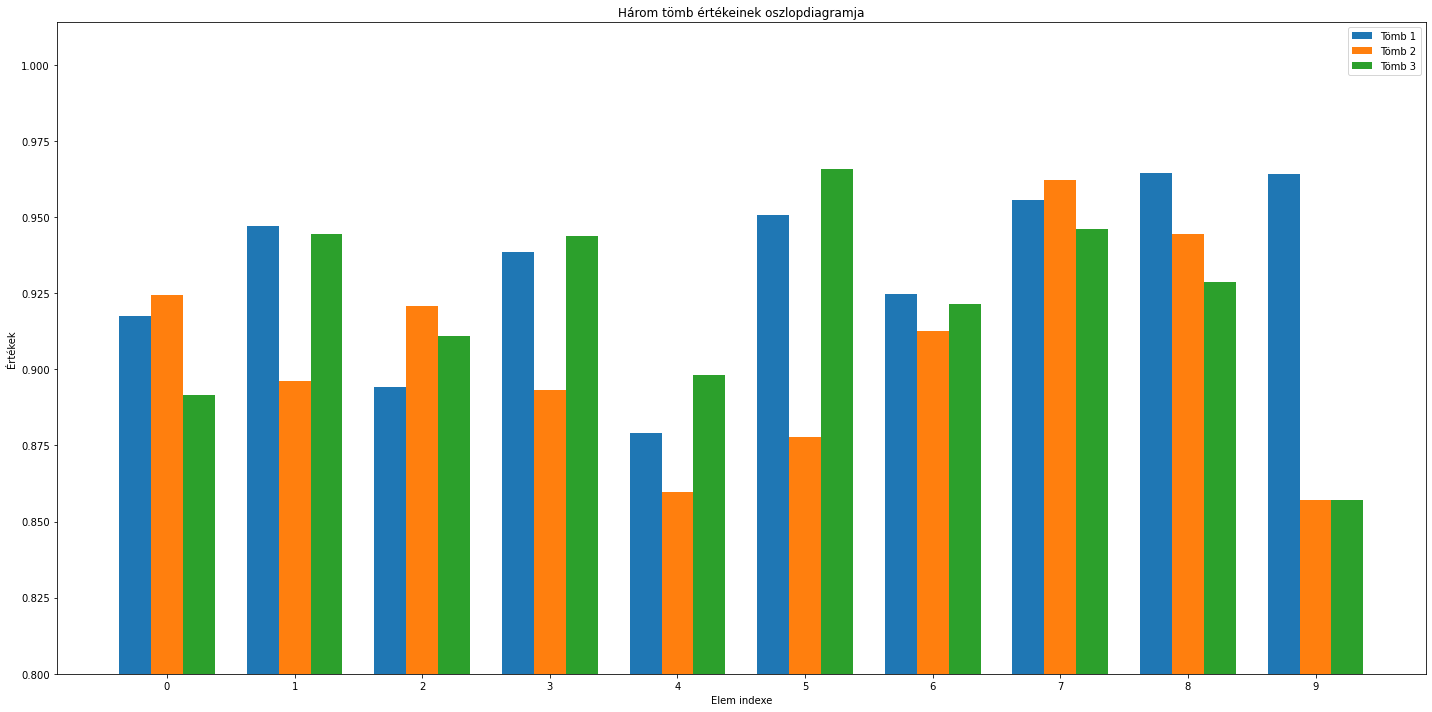

In [54]:
# Oszlopok pozíciói
bar_width = 0.25
index = np.arange(10)
plt.figure(figsize=(20,10))
# Oszlopdiagramok rajzolása
plt.bar(index, f_n2v_test_aucs, bar_width, label='With Node2Vec')
plt.bar(index + bar_width, n2v_test_aucs, bar_width, label='With original node features')
plt.bar(index + 2*bar_width, f_test_aucs, bar_width, label='With node to vec and original features')

# Címek és címkék

plt.xlabel('The graphs')
plt.ylabel('AUC scores)
plt.title('Diagram of the AUC scores of the 3 method on each subgraf')
plt.xticks(index + bar_width, range(10))
plt.legend()
plt.ylim(0.8)

# Diagram megjelenítése
plt.tight_layout()
plt.show()

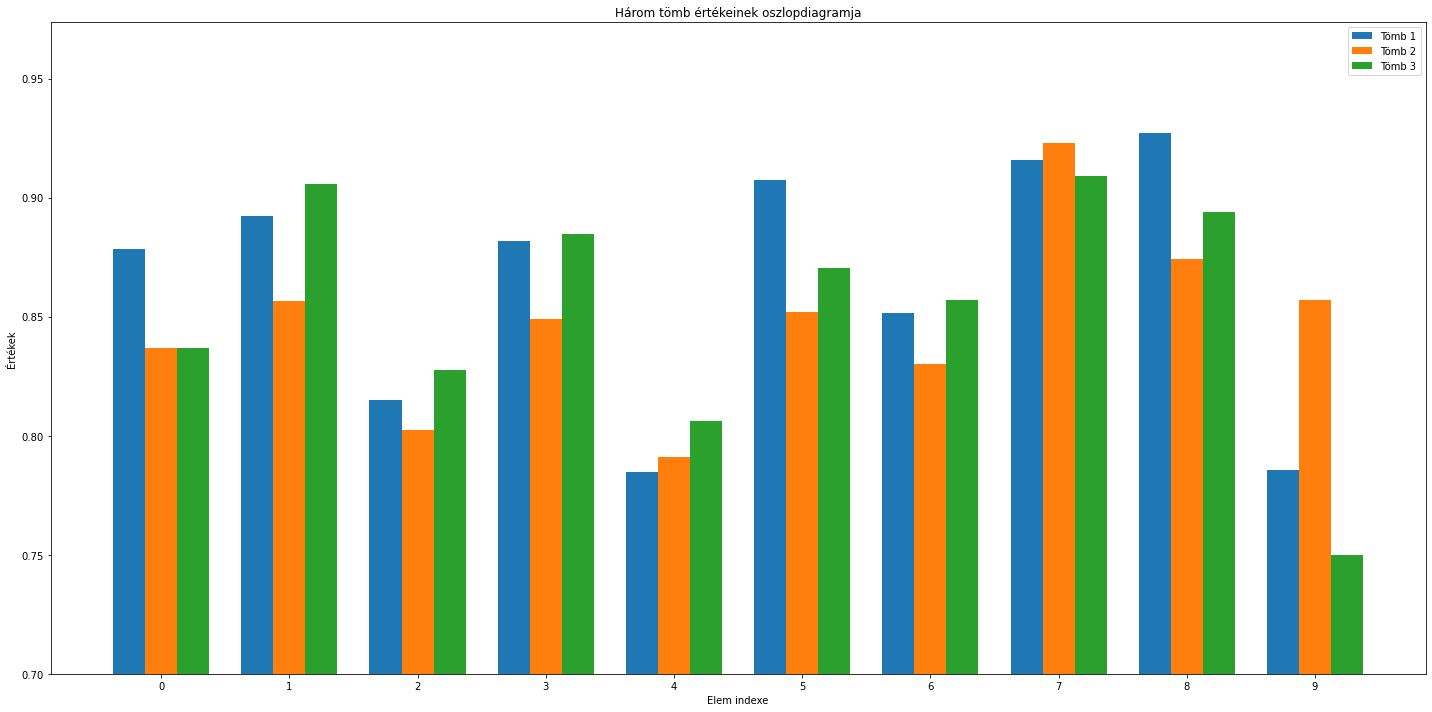

In [58]:
# Oszlopok pozíciói
bar_width = 0.25
index = np.arange(10)
plt.figure(figsize=(20,10))
# Oszlopdiagramok rajzolása
plt.bar(index, f_n2v_test_acc, bar_width, label='With Node2Vec')
plt.bar(index + bar_width, n2v_test_acc, bar_width, label='With original node features')
plt.bar(index + 2*bar_width, f_test_acc, bar_width, label='With node to vec and original features')

# Címek és címkék

plt.xlabel('The graphs')
plt.ylabel('Accuracy')
plt.title('Diagram of the accuracy of the 3 method on each subgraf')
plt.xticks(index + bar_width, range(10))
plt.legend()
plt.ylim(0.7)

# Diagram megjelenítése
plt.tight_layout()
plt.show()

In [64]:
! pip freeze

alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-anon-usage @ file:///C:/b/abs_95v3x0wy8p/croot/anaconda-anon-usage_1697038984188/work
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-cloud-auth @ file:///C:/b/abs_410afndtyf/croot/anaconda-cloud-auth_1697462767853/work
anaconda-navigator @ file:///C:/b/abs_ab00e0_u7e/croot/anaconda-navigator_1695238210954/work
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1626085644852/work
anyio @ file:///C:/ci/anyio_1620153135622/work/dist
appdirs==1.4.4
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1613037869401/work
arrow @ file:///C:/ci/arrow_1617738834352/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1629829318700/work
async-generator @ file:///home/ktietz/src/ci/async_generator_1611927993394/work
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1